In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

training_DataLoader = DataLoader(train_data, batch_size=128, shuffle=True)
testing_DataLoader = DataLoader(test_data, batch_size=128, shuffle=False)

In [3]:
class Model(nn.Module):
    def __init__(self, conv1_filters, conv2_filters, fc1_units):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(conv2_filters * 7 * 7, fc1_units)
        self.fc2 = nn.Linear(fc1_units, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
def train(model, optimizer, train_loader):
    model.train()
    loss_func = nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_loss = running_loss / total_samples
    train_acc = 100. * correct / total_samples
    return train_loss, train_acc


In [5]:
def test(model, test_loader):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    test_loss = running_loss / total_samples
    test_acc = 100. * correct / total_samples
    return test_loss, test_acc

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

models_params = [
    {'conv1_filters': 8, 'conv2_filters': 16, 'fc1_units': 64},
    {'conv1_filters': 16, 'conv2_filters': 32, 'fc1_units': 128},
    {'conv1_filters': 32, 'conv2_filters': 64, 'fc1_units': 256},
    {'conv1_filters': 64, 'conv2_filters': 128, 'fc1_units': 512},
    {'conv1_filters': 128, 'conv2_filters': 256, 'fc1_units': 1024},
    {'conv1_filters': 32, 'conv2_filters': 64, 'fc1_units': 64},
    {'conv1_filters': 64, 'conv2_filters': 128, 'fc1_units': 256},
    {'conv1_filters': 16, 'conv2_filters': 64, 'fc1_units': 512},
    {'conv1_filters': 64, 'conv2_filters': 256, 'fc1_units': 128},
    {'conv1_filters': 128, 'conv2_filters': 128, 'fc1_units': 256},
]

epochs = 10
learning_rate = 1e-4

train_loss_arr = []
test_loss_arr = []
train_acc_arr = []
test_acc_arr = []
params_arr = []

for params in models_params:
    print(f"Training model with {params}")
    model = Model(**params).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    num_params = count_parameters(model)
    params_arr.append(num_params)

    model_train_losses = []
    model_test_losses = []
    model_train_accs = []
    model_test_accs = []

    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, training_DataLoader)
        test_loss, test_acc = test(model, testing_DataLoader)

        print(f'Epoch {epoch+1}, Loss: {train_loss}, Test Loss: {test_loss}, '
              f'Train Accuracy: {train_acc}%, Test Accuracy: {test_acc}%')

        model_train_losses.append(train_loss)
        model_test_losses.append(test_loss)
        model_train_accs.append(train_acc)
        model_test_accs.append(test_acc)

    avg_train_loss = sum(model_train_losses) / epochs
    avg_test_loss = sum(model_test_losses) / epochs
    avg_train_acc = sum(model_train_accs) / epochs
    avg_test_acc = sum(model_test_accs) / epochs

    train_loss_arr.append(avg_train_loss)
    test_loss_arr.append(avg_test_loss)
    train_acc_arr.append(avg_train_acc)
    test_acc_arr.append(avg_test_acc)


Training model with {'conv1_filters': 8, 'conv2_filters': 16, 'fc1_units': 64}


100%|██████████| 469/469 [00:09<00:00, 48.12it/s]


Epoch 1/10, Train Loss: 1.020384, Test Loss: 0.366752, Train Accuracy: 73.35%, Test Accuracy: 90.29%


100%|██████████| 469/469 [00:08<00:00, 57.00it/s]


Epoch 2/10, Train Loss: 0.301668, Test Loss: 0.239186, Train Accuracy: 91.31%, Test Accuracy: 93.14%


100%|██████████| 469/469 [00:08<00:00, 57.08it/s]


Epoch 3/10, Train Loss: 0.217958, Test Loss: 0.179651, Train Accuracy: 93.62%, Test Accuracy: 94.85%


100%|██████████| 469/469 [00:08<00:00, 56.94it/s]


Epoch 4/10, Train Loss: 0.171249, Test Loss: 0.142238, Train Accuracy: 94.95%, Test Accuracy: 95.84%


100%|██████████| 469/469 [00:08<00:00, 57.13it/s]


Epoch 5/10, Train Loss: 0.139867, Test Loss: 0.121534, Train Accuracy: 95.87%, Test Accuracy: 96.23%


100%|██████████| 469/469 [00:08<00:00, 57.16it/s]


Epoch 6/10, Train Loss: 0.118112, Test Loss: 0.101657, Train Accuracy: 96.51%, Test Accuracy: 96.81%


100%|██████████| 469/469 [00:08<00:00, 57.02it/s]


Epoch 7/10, Train Loss: 0.102653, Test Loss: 0.088294, Train Accuracy: 97.01%, Test Accuracy: 97.32%


100%|██████████| 469/469 [00:08<00:00, 57.22it/s]


Epoch 8/10, Train Loss: 0.091535, Test Loss: 0.081672, Train Accuracy: 97.31%, Test Accuracy: 97.43%


100%|██████████| 469/469 [00:08<00:00, 57.16it/s]


Epoch 9/10, Train Loss: 0.083674, Test Loss: 0.077011, Train Accuracy: 97.55%, Test Accuracy: 97.49%


100%|██████████| 469/469 [00:08<00:00, 56.42it/s]


Epoch 10/10, Train Loss: 0.076747, Test Loss: 0.068963, Train Accuracy: 97.72%, Test Accuracy: 97.72%
Training model with {'conv1_filters': 16, 'conv2_filters': 32, 'fc1_units': 128}


100%|██████████| 469/469 [00:08<00:00, 56.71it/s]


Epoch 1/10, Train Loss: 0.684833, Test Loss: 0.250877, Train Accuracy: 83.88%, Test Accuracy: 92.97%


100%|██████████| 469/469 [00:08<00:00, 56.81it/s]


Epoch 2/10, Train Loss: 0.196533, Test Loss: 0.139573, Train Accuracy: 94.42%, Test Accuracy: 96.09%


100%|██████████| 469/469 [00:08<00:00, 56.82it/s]


Epoch 3/10, Train Loss: 0.125107, Test Loss: 0.099657, Train Accuracy: 96.43%, Test Accuracy: 96.99%


100%|██████████| 469/469 [00:08<00:00, 56.70it/s]


Epoch 4/10, Train Loss: 0.093513, Test Loss: 0.078116, Train Accuracy: 97.23%, Test Accuracy: 97.54%


100%|██████████| 469/469 [00:08<00:00, 56.78it/s]


Epoch 5/10, Train Loss: 0.076768, Test Loss: 0.068537, Train Accuracy: 97.74%, Test Accuracy: 97.71%


100%|██████████| 469/469 [00:08<00:00, 56.80it/s]


Epoch 6/10, Train Loss: 0.066426, Test Loss: 0.057293, Train Accuracy: 98.03%, Test Accuracy: 98.13%


100%|██████████| 469/469 [00:08<00:00, 56.72it/s]


Epoch 7/10, Train Loss: 0.058975, Test Loss: 0.051160, Train Accuracy: 98.23%, Test Accuracy: 98.25%


100%|██████████| 469/469 [00:08<00:00, 56.89it/s]


Epoch 8/10, Train Loss: 0.053754, Test Loss: 0.054980, Train Accuracy: 98.41%, Test Accuracy: 98.12%


100%|██████████| 469/469 [00:08<00:00, 56.90it/s]


Epoch 9/10, Train Loss: 0.048772, Test Loss: 0.048591, Train Accuracy: 98.52%, Test Accuracy: 98.40%


100%|██████████| 469/469 [00:08<00:00, 56.76it/s]


Epoch 10/10, Train Loss: 0.045736, Test Loss: 0.044927, Train Accuracy: 98.60%, Test Accuracy: 98.40%
Training model with {'conv1_filters': 32, 'conv2_filters': 64, 'fc1_units': 256}


100%|██████████| 469/469 [00:08<00:00, 55.61it/s]


Epoch 1/10, Train Loss: 0.441876, Test Loss: 0.141672, Train Accuracy: 89.03%, Test Accuracy: 96.13%


100%|██████████| 469/469 [00:08<00:00, 55.66it/s]


Epoch 2/10, Train Loss: 0.116098, Test Loss: 0.079298, Train Accuracy: 96.68%, Test Accuracy: 97.65%


100%|██████████| 469/469 [00:08<00:00, 55.56it/s]


Epoch 3/10, Train Loss: 0.076353, Test Loss: 0.057688, Train Accuracy: 97.75%, Test Accuracy: 98.20%


100%|██████████| 469/469 [00:08<00:00, 55.65it/s]


Epoch 4/10, Train Loss: 0.060482, Test Loss: 0.054705, Train Accuracy: 98.21%, Test Accuracy: 98.40%


100%|██████████| 469/469 [00:08<00:00, 55.72it/s]


Epoch 5/10, Train Loss: 0.050230, Test Loss: 0.046939, Train Accuracy: 98.53%, Test Accuracy: 98.53%


100%|██████████| 469/469 [00:08<00:00, 55.62it/s]


Epoch 6/10, Train Loss: 0.044027, Test Loss: 0.039781, Train Accuracy: 98.69%, Test Accuracy: 98.72%


100%|██████████| 469/469 [00:08<00:00, 55.66it/s]


Epoch 7/10, Train Loss: 0.038598, Test Loss: 0.038348, Train Accuracy: 98.85%, Test Accuracy: 98.78%


100%|██████████| 469/469 [00:08<00:00, 55.70it/s]


Epoch 8/10, Train Loss: 0.034459, Test Loss: 0.034010, Train Accuracy: 98.94%, Test Accuracy: 98.79%


100%|██████████| 469/469 [00:08<00:00, 55.58it/s]


Epoch 9/10, Train Loss: 0.030416, Test Loss: 0.032384, Train Accuracy: 99.05%, Test Accuracy: 98.95%


100%|██████████| 469/469 [00:08<00:00, 55.81it/s]


Epoch 10/10, Train Loss: 0.027457, Test Loss: 0.032207, Train Accuracy: 99.16%, Test Accuracy: 98.90%
Training model with {'conv1_filters': 64, 'conv2_filters': 128, 'fc1_units': 512}


100%|██████████| 469/469 [00:09<00:00, 51.90it/s]


Epoch 1/10, Train Loss: 0.286835, Test Loss: 0.081165, Train Accuracy: 92.08%, Test Accuracy: 97.59%


100%|██████████| 469/469 [00:08<00:00, 52.22it/s]


Epoch 2/10, Train Loss: 0.076310, Test Loss: 0.056631, Train Accuracy: 97.74%, Test Accuracy: 98.16%


100%|██████████| 469/469 [00:08<00:00, 52.27it/s]


Epoch 3/10, Train Loss: 0.051896, Test Loss: 0.042775, Train Accuracy: 98.42%, Test Accuracy: 98.60%


100%|██████████| 469/469 [00:08<00:00, 52.30it/s]


Epoch 4/10, Train Loss: 0.041805, Test Loss: 0.037765, Train Accuracy: 98.75%, Test Accuracy: 98.72%


100%|██████████| 469/469 [00:08<00:00, 52.23it/s]


Epoch 5/10, Train Loss: 0.034150, Test Loss: 0.032310, Train Accuracy: 98.98%, Test Accuracy: 98.85%


100%|██████████| 469/469 [00:08<00:00, 52.35it/s]


Epoch 6/10, Train Loss: 0.028917, Test Loss: 0.031943, Train Accuracy: 99.08%, Test Accuracy: 98.87%


100%|██████████| 469/469 [00:08<00:00, 52.30it/s]


Epoch 7/10, Train Loss: 0.024232, Test Loss: 0.033593, Train Accuracy: 99.29%, Test Accuracy: 98.83%


100%|██████████| 469/469 [00:08<00:00, 52.17it/s]


Epoch 8/10, Train Loss: 0.020189, Test Loss: 0.029044, Train Accuracy: 99.39%, Test Accuracy: 99.07%


100%|██████████| 469/469 [00:08<00:00, 52.29it/s]


Epoch 9/10, Train Loss: 0.016816, Test Loss: 0.029637, Train Accuracy: 99.51%, Test Accuracy: 98.91%


100%|██████████| 469/469 [00:09<00:00, 51.69it/s]


Epoch 10/10, Train Loss: 0.014714, Test Loss: 0.033159, Train Accuracy: 99.54%, Test Accuracy: 98.85%
Training model with {'conv1_filters': 128, 'conv2_filters': 256, 'fc1_units': 1024}


100%|██████████| 469/469 [00:10<00:00, 43.14it/s]


Epoch 1/10, Train Loss: 0.184264, Test Loss: 0.055461, Train Accuracy: 94.56%, Test Accuracy: 98.31%


100%|██████████| 469/469 [00:10<00:00, 44.10it/s]


Epoch 2/10, Train Loss: 0.052071, Test Loss: 0.040606, Train Accuracy: 98.45%, Test Accuracy: 98.64%


100%|██████████| 469/469 [00:10<00:00, 44.08it/s]


Epoch 3/10, Train Loss: 0.037062, Test Loss: 0.034443, Train Accuracy: 98.86%, Test Accuracy: 98.83%


100%|██████████| 469/469 [00:10<00:00, 44.09it/s]


Epoch 4/10, Train Loss: 0.027019, Test Loss: 0.034457, Train Accuracy: 99.20%, Test Accuracy: 98.83%


100%|██████████| 469/469 [00:10<00:00, 44.09it/s]


Epoch 5/10, Train Loss: 0.021647, Test Loss: 0.027868, Train Accuracy: 99.32%, Test Accuracy: 99.09%


100%|██████████| 469/469 [00:10<00:00, 44.06it/s]


Epoch 6/10, Train Loss: 0.016155, Test Loss: 0.025186, Train Accuracy: 99.48%, Test Accuracy: 99.16%


100%|██████████| 469/469 [00:10<00:00, 44.18it/s]


Epoch 7/10, Train Loss: 0.013386, Test Loss: 0.028088, Train Accuracy: 99.57%, Test Accuracy: 99.05%


100%|██████████| 469/469 [00:10<00:00, 44.06it/s]


Epoch 8/10, Train Loss: 0.009809, Test Loss: 0.031301, Train Accuracy: 99.71%, Test Accuracy: 98.98%


100%|██████████| 469/469 [00:10<00:00, 44.10it/s]


Epoch 9/10, Train Loss: 0.008478, Test Loss: 0.023273, Train Accuracy: 99.72%, Test Accuracy: 99.21%


100%|██████████| 469/469 [00:10<00:00, 44.09it/s]


Epoch 10/10, Train Loss: 0.007400, Test Loss: 0.025063, Train Accuracy: 99.78%, Test Accuracy: 99.22%
Training model with {'conv1_filters': 32, 'conv2_filters': 64, 'fc1_units': 64}


100%|██████████| 469/469 [00:08<00:00, 56.03it/s]


Epoch 1/10, Train Loss: 0.635754, Test Loss: 0.201394, Train Accuracy: 83.66%, Test Accuracy: 94.40%


100%|██████████| 469/469 [00:08<00:00, 56.16it/s]


Epoch 2/10, Train Loss: 0.163719, Test Loss: 0.121958, Train Accuracy: 95.33%, Test Accuracy: 96.45%


100%|██████████| 469/469 [00:08<00:00, 56.18it/s]


Epoch 3/10, Train Loss: 0.108382, Test Loss: 0.083596, Train Accuracy: 96.88%, Test Accuracy: 97.46%


100%|██████████| 469/469 [00:08<00:00, 56.02it/s]


Epoch 4/10, Train Loss: 0.083541, Test Loss: 0.068502, Train Accuracy: 97.55%, Test Accuracy: 97.88%


100%|██████████| 469/469 [00:08<00:00, 56.01it/s]


Epoch 5/10, Train Loss: 0.070020, Test Loss: 0.061421, Train Accuracy: 97.95%, Test Accuracy: 97.99%


100%|██████████| 469/469 [00:08<00:00, 56.07it/s]


Epoch 6/10, Train Loss: 0.061555, Test Loss: 0.053115, Train Accuracy: 98.19%, Test Accuracy: 98.31%


100%|██████████| 469/469 [00:08<00:00, 55.97it/s]


Epoch 7/10, Train Loss: 0.055041, Test Loss: 0.046710, Train Accuracy: 98.39%, Test Accuracy: 98.53%


100%|██████████| 469/469 [00:08<00:00, 56.14it/s]


Epoch 8/10, Train Loss: 0.049469, Test Loss: 0.044564, Train Accuracy: 98.55%, Test Accuracy: 98.50%


100%|██████████| 469/469 [00:08<00:00, 56.11it/s]


Epoch 9/10, Train Loss: 0.045718, Test Loss: 0.040886, Train Accuracy: 98.63%, Test Accuracy: 98.62%


100%|██████████| 469/469 [00:08<00:00, 55.98it/s]


Epoch 10/10, Train Loss: 0.042329, Test Loss: 0.040459, Train Accuracy: 98.75%, Test Accuracy: 98.57%
Training model with {'conv1_filters': 64, 'conv2_filters': 128, 'fc1_units': 256}


100%|██████████| 469/469 [00:08<00:00, 53.07it/s]


Epoch 1/10, Train Loss: 0.315357, Test Loss: 0.109640, Train Accuracy: 91.61%, Test Accuracy: 96.89%


100%|██████████| 469/469 [00:08<00:00, 53.08it/s]


Epoch 2/10, Train Loss: 0.086050, Test Loss: 0.056272, Train Accuracy: 97.51%, Test Accuracy: 98.20%


100%|██████████| 469/469 [00:08<00:00, 53.04it/s]


Epoch 3/10, Train Loss: 0.059319, Test Loss: 0.049176, Train Accuracy: 98.25%, Test Accuracy: 98.32%


100%|██████████| 469/469 [00:08<00:00, 53.18it/s]


Epoch 4/10, Train Loss: 0.046954, Test Loss: 0.042750, Train Accuracy: 98.61%, Test Accuracy: 98.61%


100%|██████████| 469/469 [00:08<00:00, 53.10it/s]


Epoch 5/10, Train Loss: 0.038305, Test Loss: 0.038782, Train Accuracy: 98.82%, Test Accuracy: 98.58%


100%|██████████| 469/469 [00:08<00:00, 53.00it/s]


Epoch 6/10, Train Loss: 0.033313, Test Loss: 0.037214, Train Accuracy: 98.97%, Test Accuracy: 98.72%


100%|██████████| 469/469 [00:08<00:00, 53.04it/s]


Epoch 7/10, Train Loss: 0.029644, Test Loss: 0.030500, Train Accuracy: 99.10%, Test Accuracy: 98.96%


100%|██████████| 469/469 [00:09<00:00, 48.69it/s]


Epoch 8/10, Train Loss: 0.026282, Test Loss: 0.031884, Train Accuracy: 99.21%, Test Accuracy: 98.86%


100%|██████████| 469/469 [00:10<00:00, 42.86it/s]


Epoch 9/10, Train Loss: 0.022167, Test Loss: 0.029856, Train Accuracy: 99.33%, Test Accuracy: 99.03%


100%|██████████| 469/469 [00:10<00:00, 43.21it/s]


Epoch 10/10, Train Loss: 0.018622, Test Loss: 0.032000, Train Accuracy: 99.45%, Test Accuracy: 98.96%
Training model with {'conv1_filters': 16, 'conv2_filters': 64, 'fc1_units': 512}


100%|██████████| 469/469 [00:10<00:00, 46.83it/s]


Epoch 1/10, Train Loss: 0.430081, Test Loss: 0.142402, Train Accuracy: 89.69%, Test Accuracy: 96.08%


100%|██████████| 469/469 [00:08<00:00, 55.75it/s]


Epoch 2/10, Train Loss: 0.110934, Test Loss: 0.078564, Train Accuracy: 96.78%, Test Accuracy: 97.59%


100%|██████████| 469/469 [00:08<00:00, 56.03it/s]


Epoch 3/10, Train Loss: 0.072891, Test Loss: 0.060197, Train Accuracy: 97.88%, Test Accuracy: 98.19%


100%|██████████| 469/469 [00:08<00:00, 56.00it/s]


Epoch 4/10, Train Loss: 0.058096, Test Loss: 0.048848, Train Accuracy: 98.30%, Test Accuracy: 98.43%


100%|██████████| 469/469 [00:08<00:00, 56.04it/s]


Epoch 5/10, Train Loss: 0.048216, Test Loss: 0.043506, Train Accuracy: 98.55%, Test Accuracy: 98.73%


100%|██████████| 469/469 [00:08<00:00, 56.05it/s]


Epoch 6/10, Train Loss: 0.042175, Test Loss: 0.054806, Train Accuracy: 98.78%, Test Accuracy: 98.23%


100%|██████████| 469/469 [00:08<00:00, 56.04it/s]


Epoch 7/10, Train Loss: 0.037338, Test Loss: 0.041907, Train Accuracy: 98.90%, Test Accuracy: 98.77%


100%|██████████| 469/469 [00:08<00:00, 56.12it/s]


Epoch 8/10, Train Loss: 0.033515, Test Loss: 0.036853, Train Accuracy: 99.02%, Test Accuracy: 98.87%


100%|██████████| 469/469 [00:08<00:00, 56.13it/s]


Epoch 9/10, Train Loss: 0.029698, Test Loss: 0.036324, Train Accuracy: 99.12%, Test Accuracy: 98.81%


100%|██████████| 469/469 [00:08<00:00, 56.07it/s]


Epoch 10/10, Train Loss: 0.027380, Test Loss: 0.033232, Train Accuracy: 99.20%, Test Accuracy: 98.81%
Training model with {'conv1_filters': 64, 'conv2_filters': 256, 'fc1_units': 128}


100%|██████████| 469/469 [00:09<00:00, 50.45it/s]


Epoch 1/10, Train Loss: 0.290112, Test Loss: 0.086429, Train Accuracy: 92.20%, Test Accuracy: 97.55%


100%|██████████| 469/469 [00:09<00:00, 50.52it/s]


Epoch 2/10, Train Loss: 0.076257, Test Loss: 0.064422, Train Accuracy: 97.83%, Test Accuracy: 97.96%


100%|██████████| 469/469 [00:09<00:00, 50.40it/s]


Epoch 3/10, Train Loss: 0.053119, Test Loss: 0.043174, Train Accuracy: 98.44%, Test Accuracy: 98.53%


100%|██████████| 469/469 [00:09<00:00, 50.51it/s]


Epoch 4/10, Train Loss: 0.043938, Test Loss: 0.041473, Train Accuracy: 98.66%, Test Accuracy: 98.60%


100%|██████████| 469/469 [00:09<00:00, 50.48it/s]


Epoch 5/10, Train Loss: 0.035460, Test Loss: 0.037399, Train Accuracy: 98.93%, Test Accuracy: 98.79%


100%|██████████| 469/469 [00:09<00:00, 50.47it/s]


Epoch 6/10, Train Loss: 0.030314, Test Loss: 0.034730, Train Accuracy: 99.08%, Test Accuracy: 98.73%


100%|██████████| 469/469 [00:09<00:00, 50.58it/s]


Epoch 7/10, Train Loss: 0.025882, Test Loss: 0.031615, Train Accuracy: 99.20%, Test Accuracy: 98.86%


100%|██████████| 469/469 [00:09<00:00, 50.54it/s]


Epoch 8/10, Train Loss: 0.022399, Test Loss: 0.035550, Train Accuracy: 99.30%, Test Accuracy: 98.82%


100%|██████████| 469/469 [00:09<00:00, 50.44it/s]


Epoch 9/10, Train Loss: 0.019368, Test Loss: 0.031597, Train Accuracy: 99.41%, Test Accuracy: 98.95%


100%|██████████| 469/469 [00:09<00:00, 50.25it/s]


Epoch 10/10, Train Loss: 0.016616, Test Loss: 0.028127, Train Accuracy: 99.48%, Test Accuracy: 99.01%
Training model with {'conv1_filters': 128, 'conv2_filters': 128, 'fc1_units': 256}


100%|██████████| 469/469 [00:09<00:00, 50.30it/s]


Epoch 1/10, Train Loss: 0.275931, Test Loss: 0.083193, Train Accuracy: 92.10%, Test Accuracy: 97.50%


100%|██████████| 469/469 [00:09<00:00, 50.20it/s]


Epoch 2/10, Train Loss: 0.075208, Test Loss: 0.053582, Train Accuracy: 97.77%, Test Accuracy: 98.33%


100%|██████████| 469/469 [00:09<00:00, 50.43it/s]


Epoch 3/10, Train Loss: 0.051103, Test Loss: 0.040888, Train Accuracy: 98.44%, Test Accuracy: 98.61%


100%|██████████| 469/469 [00:09<00:00, 50.47it/s]


Epoch 4/10, Train Loss: 0.041423, Test Loss: 0.035642, Train Accuracy: 98.73%, Test Accuracy: 98.77%


100%|██████████| 469/469 [00:09<00:00, 50.34it/s]


Epoch 5/10, Train Loss: 0.033333, Test Loss: 0.035189, Train Accuracy: 98.98%, Test Accuracy: 98.74%


100%|██████████| 469/469 [00:09<00:00, 50.42it/s]


Epoch 6/10, Train Loss: 0.028366, Test Loss: 0.029976, Train Accuracy: 99.14%, Test Accuracy: 98.95%


100%|██████████| 469/469 [00:09<00:00, 49.51it/s]


Epoch 7/10, Train Loss: 0.023283, Test Loss: 0.028118, Train Accuracy: 99.30%, Test Accuracy: 99.07%


100%|██████████| 469/469 [00:09<00:00, 49.68it/s]


Epoch 8/10, Train Loss: 0.019000, Test Loss: 0.027125, Train Accuracy: 99.44%, Test Accuracy: 99.13%


100%|██████████| 469/469 [00:09<00:00, 50.42it/s]


Epoch 9/10, Train Loss: 0.016232, Test Loss: 0.028288, Train Accuracy: 99.55%, Test Accuracy: 99.02%


100%|██████████| 469/469 [00:09<00:00, 50.41it/s]


Epoch 10/10, Train Loss: 0.013633, Test Loss: 0.025873, Train Accuracy: 99.58%, Test Accuracy: 99.11%


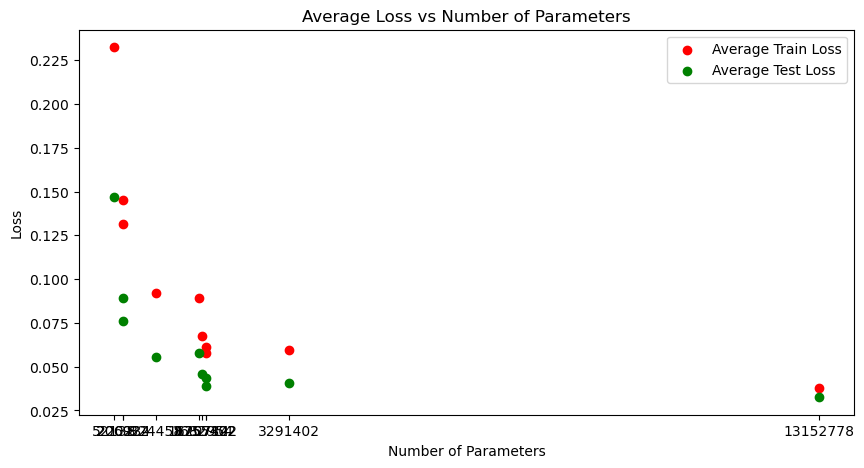

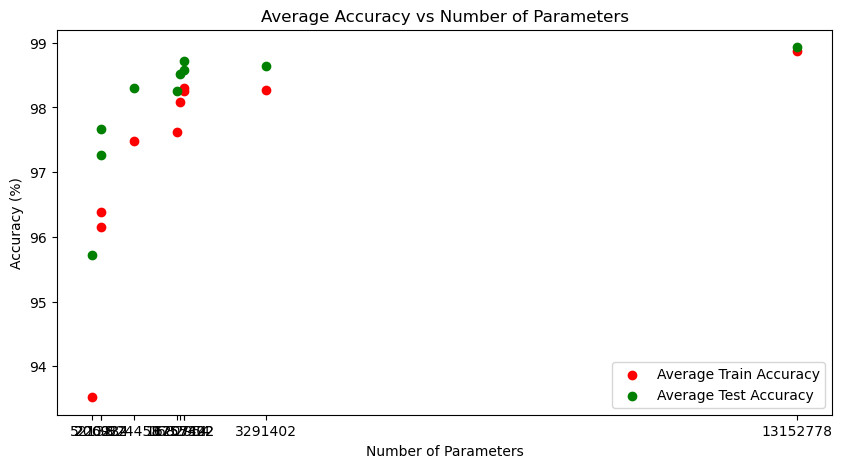

In [7]:
plt.figure(figsize=(10, 5))
plt.scatter(params_arr, train_loss_arr, color="red", label="Average Train Loss")
plt.scatter(params_arr, test_loss_arr, color="green", label="Average Test Loss")
plt.xticks(params_arr, params_arr)
plt.legend()
plt.title('Average Loss vs Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(params_arr, train_acc_arr, color="red", label="Average Train Accuracy")
plt.scatter(params_arr, test_acc_arr, color="green", label="Average Test Accuracy")
plt.xticks(params_arr, params_arr)
plt.legend()
plt.title('Average Accuracy vs Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.show()

In [8]:
len(train_loss_arr) 


10